<a href="https://colab.research.google.com/github/Abdulmuj33b/TechCrush_Capstone_TeamStark/blob/main/notebooks/Team_Stark_Heart_Disease_Pridictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploratory Data Analysis (EDA)**

This section:

- Loads `heart.xls` from `/content/drive/Mydrive/heart-disease-project/data`
- Cleans and summarizes the dataset
- Produces visualizations (displayed inline) and saves them to `images/`
- Performs simple statistical tests (t-test for numeric vs target, chi-square for categorical (if available) vs target)
- Prints short quick insights after each analytical step


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Standard Imports

In [4]:


# Standard imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay
from imblearn.over_sampling import SMOTE
import joblib
from IPython.display import display

# Make plots look nicer
%matplotlib inline
sns.set(style='whitegrid')

# Paths - consolidated
DATA_PATH = '/content/drive/MyDrive/heart-disease-project/data/heart.xls'
CLEAN_PATH = '/content/drive/MyDrive/heart-disease-project/data/cleaned.heart.csv'
IMAGES_DIR = os.path.join('/content/drive/MyDrive/heart-disease-project/images')
os.makedirs(IMAGES_DIR, exist_ok=True)
print('Images will be saved to:', IMAGES_DIR)



Images will be saved to: /content/drive/MyDrive/heart-disease-project/images


In [5]:
!pip install xlrd

# 2. Load the data

In [6]:
df = pd.read_csv(DATA_PATH)
print('Initial shape:', df.shape)
display(df.head())

Initial shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


##3. Basic cleaning function (lowercase cols, strip whitespace, replace empty strings)

In [7]:
# Basic cleaning function (lowercase cols, strip whitespace, replace empty strings)
def basic_clean(df):
    df = df.copy()
    df.columns = [str(c).strip().lower().replace(' ', '_') for c in df.columns]
    df = df.replace(r'^\s*$', np.nan, regex=True)
    return df

df = basic_clean(df)
print('After basic cleaning shape:', df.shape)
display(df.head())

After basic cleaning shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


##4. Identify Duplicate Rows

In [8]:
# Identify duplicate rows
duplicate_rows = df[df.duplicated()]

# Display the head of the duplicate rows
print("Head of duplicate rows:")
display(duplicate_rows.head())

# Print the total number of duplicate rows
print("\nTotal number of duplicate rows:", duplicate_rows.shape[0])

Head of duplicate rows:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
15,34,0,1,118,210,0,1,192,0,0.7,2,0,2,1
31,50,0,1,120,244,0,1,162,0,1.1,2,0,2,1
43,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
55,55,1,0,140,217,0,1,111,1,5.6,0,0,3,0
61,66,0,2,146,278,0,0,152,0,0.0,1,1,2,1



Total number of duplicate rows: 723


## 5. Why We Kept Duplicates in This Health Dataset

We did not remove duplicate rows in this health dataset because:

*   **Multiple visits/events:** Patients can have multiple records representing different visits or medical events.
*   **Different observations:** Multiple valid observations might exist for the same patient at a given time.
*   **Data nuances:** The data collection process can result in seemingly duplicate, but valid, entries.

Keeping these rows preserves the full patient history and avoids losing important information.

##6. Ensuring Target Exists in Binary

In [9]:
# Ensure target exists and is binary
if 'target' not in df.columns:
    raise KeyError("The dataset must contain a 'target' column with 0/1 values indicating heart disease.")
print('Target unique values:', df['target'].unique())


Target unique values: [0 1]


##7. Quick summary & missingness


In [10]:
display(df.info())
display(df.describe(include='all').T)

# Missing values summary
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing>0]
print('\nColumns with missing values:\n')
print(missing)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


None

,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
sex,1025.0,0.695610,0.460373,0.0,0.0,1.0,1.0,1.0
cp,1025.0,0.942439,1.029641,0.0,0.0,1.0,2.0,3.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
fbs,1025.0,0.149268,0.356527,0.0,0.0,0.0,0.0,1.0
restecg,1025.0,0.529756,0.527878,0.0,0.0,1.0,1.0,2.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
exang,1025.0,0.336585,0.472772,0.0,0.0,0.0,1.0,1.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2



Columns with missing values:

Series([], dtype: int64)


##8. Class Distribution (target)


In [ ]:
ax = df['target'].value_counts().sort_index().plot(kind='bar', color=['blue', 'red'])
ax.set_xticklabels(['No Disease (0)','Disease (1)'], rotation=0)
ax.set_ylabel('Count')
ax.set_title('Target class distribution')
plt.tight_layout()
fn = os.path.join(IMAGES_DIR, 'target_distribution.png')
plt.savefig(fn, dpi=150)
plt.show()
print('\nQuick-insight:')
counts = df['target'].value_counts().sort_index()
if counts.shape[0]==2:
    pct_disease = counts.loc[1] / counts.sum()
    print(f"Proportion with heart disease: {pct_disease:.2%} (class=1).")
    pct_no_disease = counts.loc[0] / counts.sum()
    print(f"Proportion without heart disease: {pct_no_disease:.2%} (class=0).")
    print("This indicates whether class imbalance handling may be needed.")
else:
    print('Target is not binary or unexpected unique values.')

##9. Identifying Numeric and Categorical Columns


This is crucial because it determines how we process, visualize, and prepare the data for modeling as different data types require different methods.

In [11]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print('Numeric columns:', num_cols)
print('Categorical columns:', cat_cols)


Numeric columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
Categorical columns: []


##10. Univariate Analysis (Numeric features)

It helps us to understand:

    Distribution patterns of individual variables (normal, skewed, uniform)

    Central tendency through mean, median, and mode

    Data spread via range, variance, and standard deviation

    Presence of outliers that may need special treatment

    Overall characteristics of each feature in isolation

This foundational understanding informs subsequent data preprocessing and guides more complex multivariate analysis.

For each numeric feature we will plot a histogram and boxplot, save them, and compute skewness.

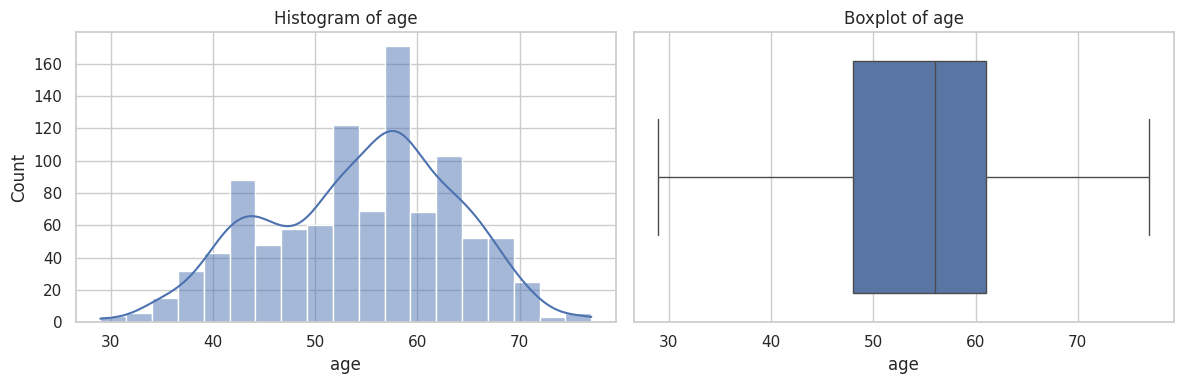

age — skewness: -0.25


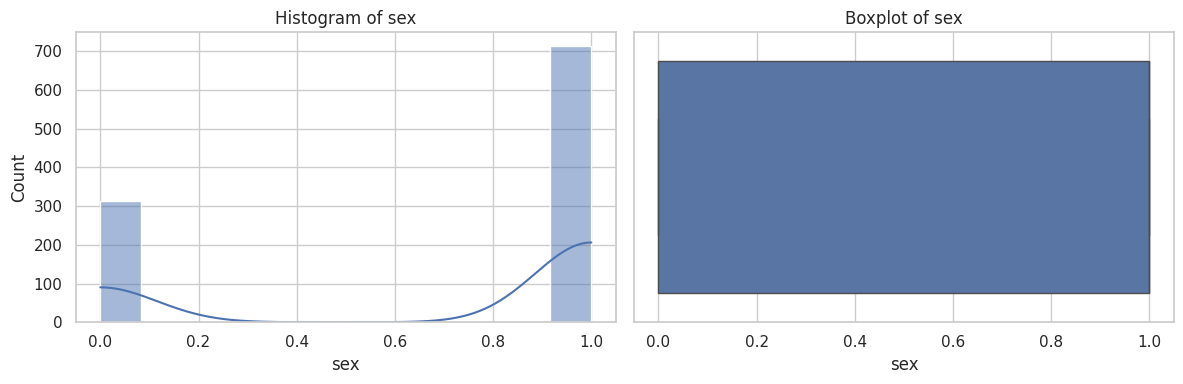

sex — skewness: -0.85


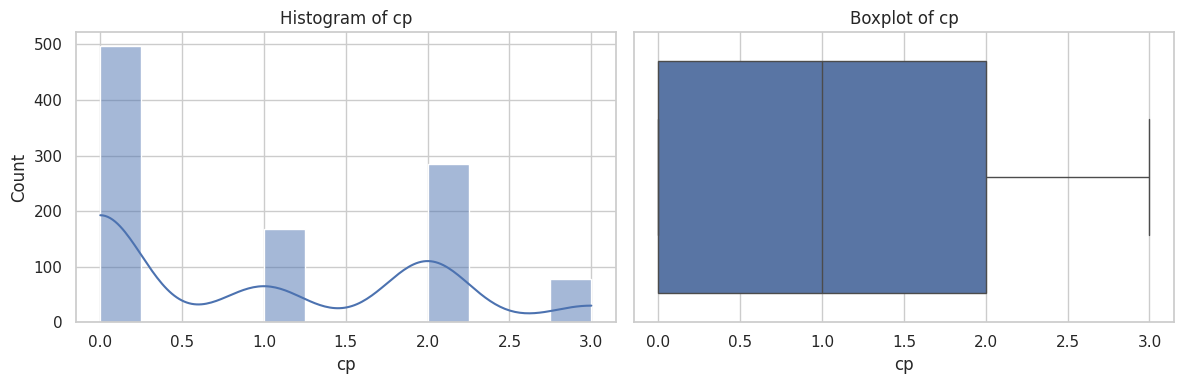

cp — skewness: 0.53


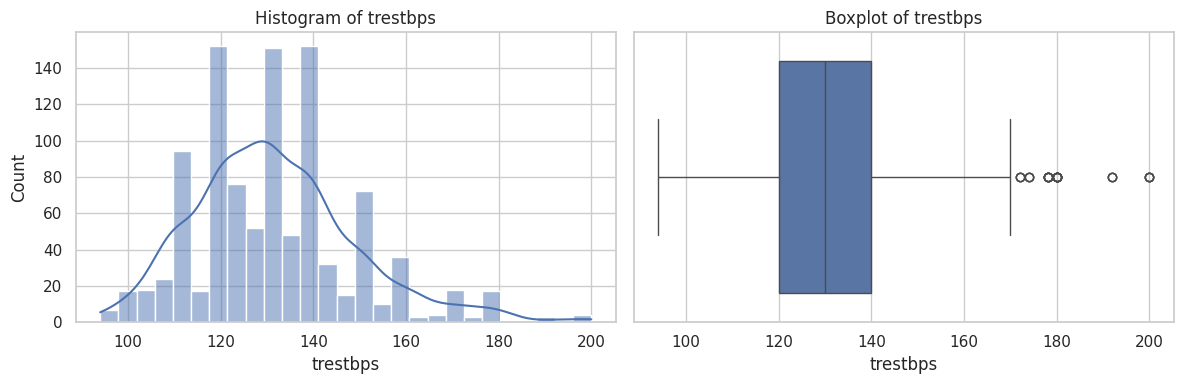

trestbps — skewness: 0.74


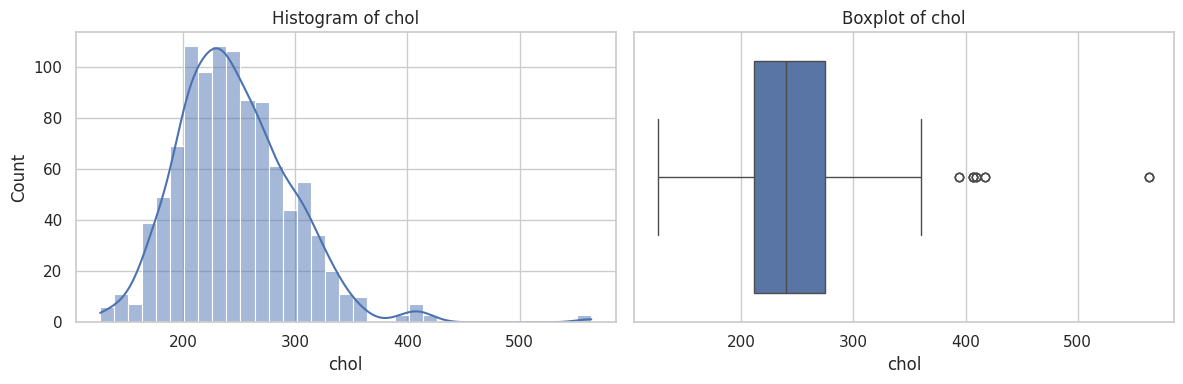

chol — skewness: 1.07


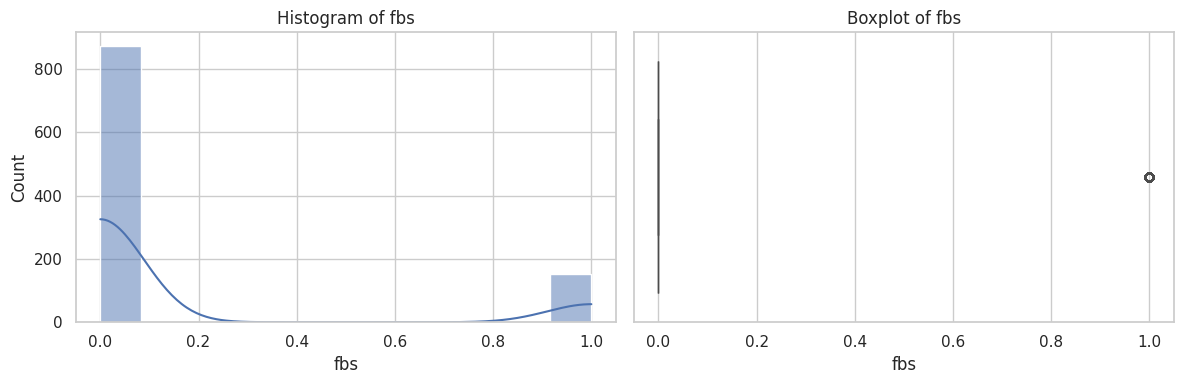

fbs — skewness: 1.97


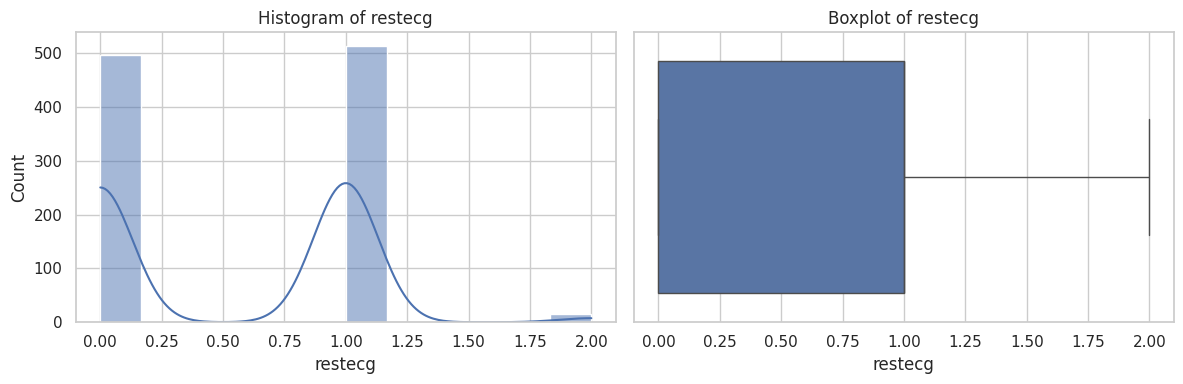

restecg — skewness: 0.18


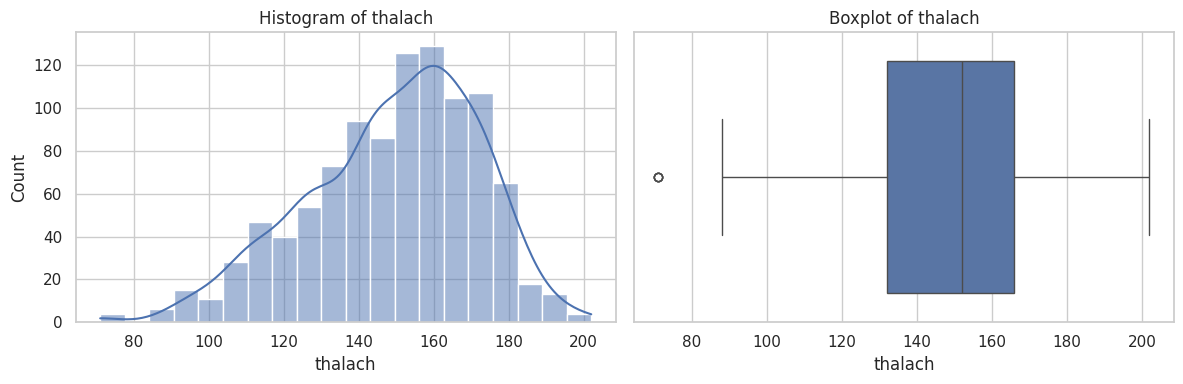

thalach — skewness: -0.51


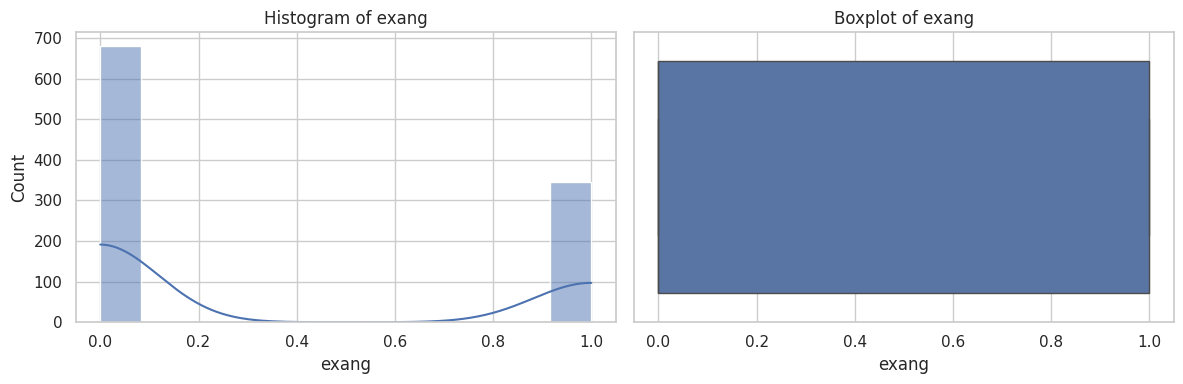

exang — skewness: 0.69


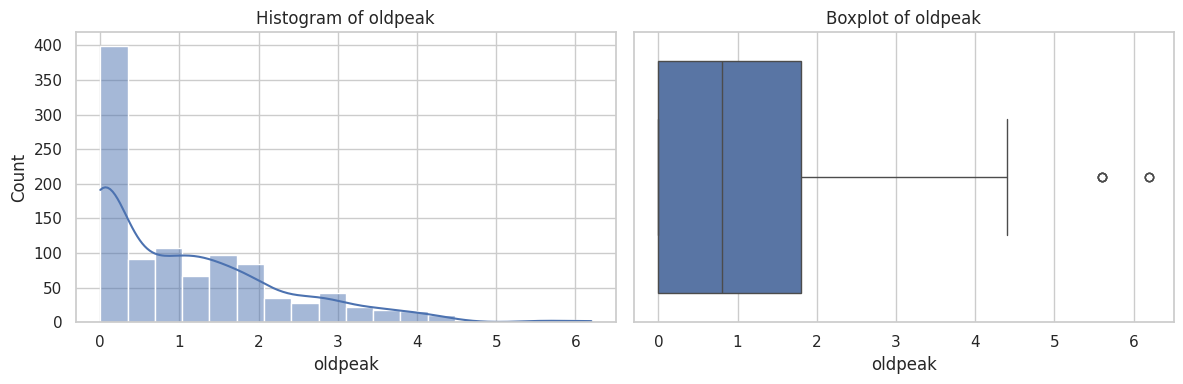

oldpeak — skewness: 1.21


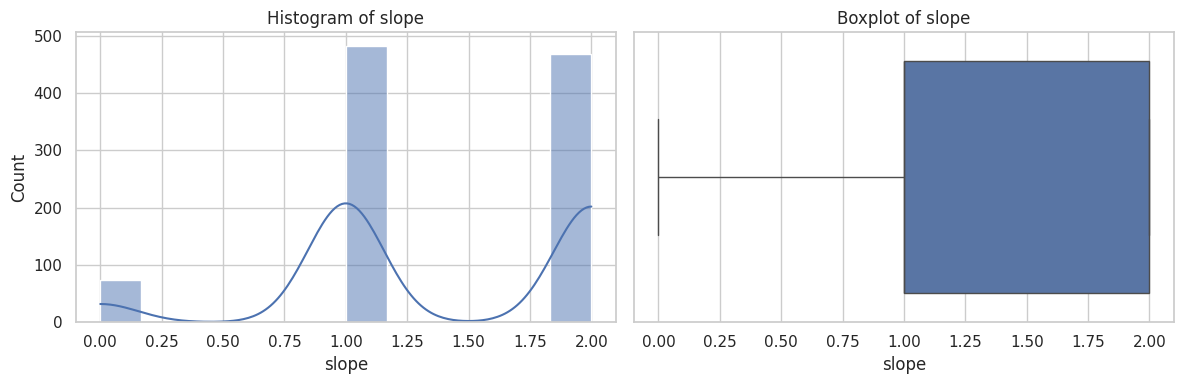

slope — skewness: -0.48


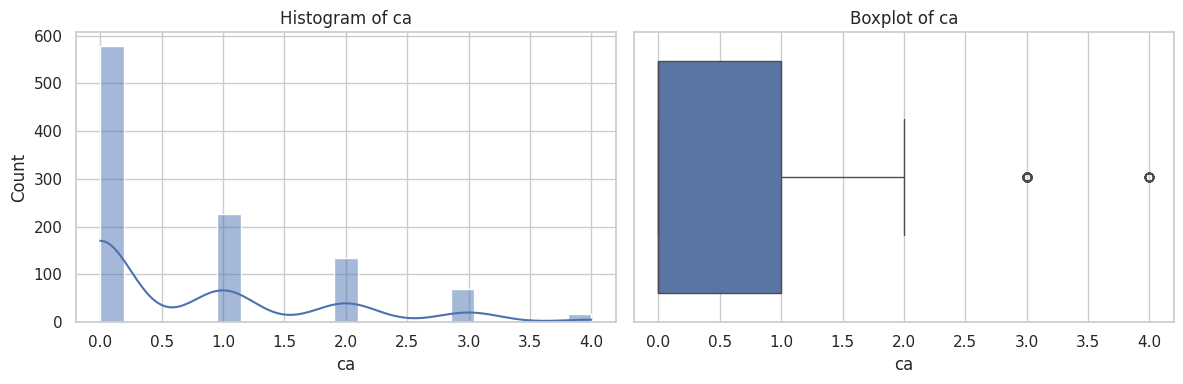

ca — skewness: 1.26


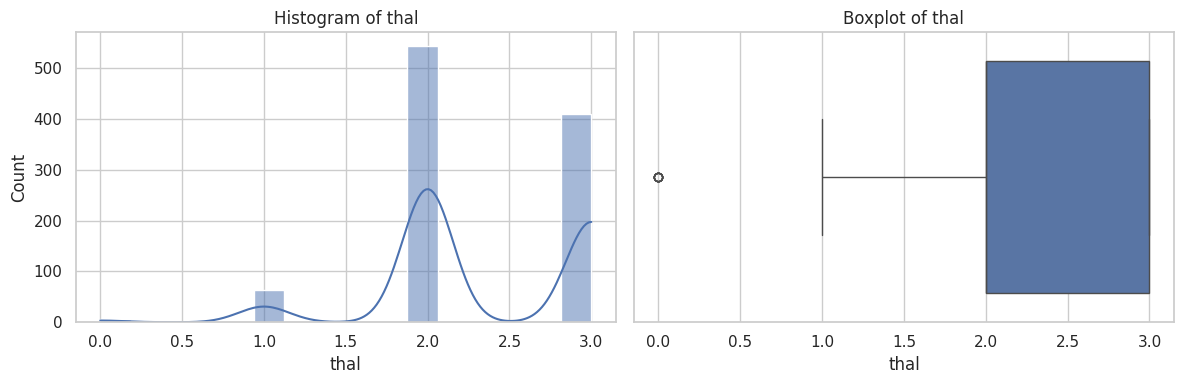

thal — skewness: -0.52


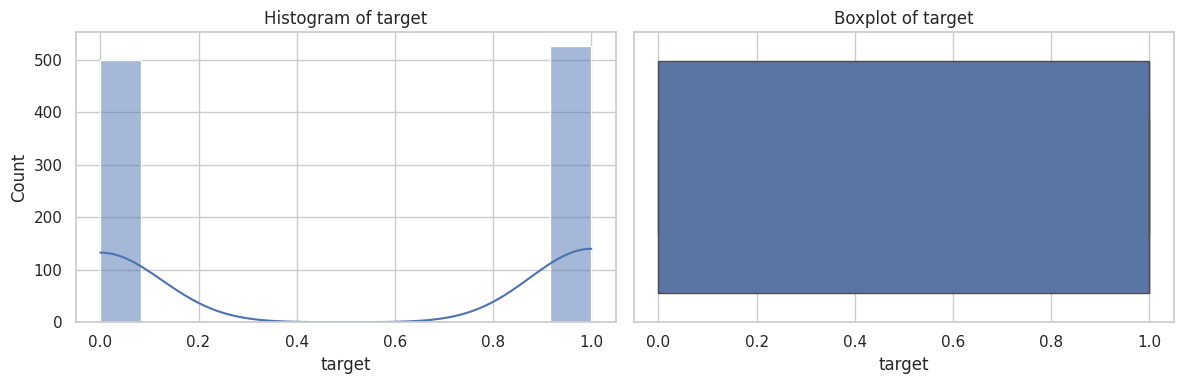

target — skewness: -0.05


In [12]:
for col in num_cols:
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(df[col].dropna(), kde=True, ax=axes[0])
    axes[0].set_title(f'Histogram of {col}')
    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f'Boxplot of {col}')
    plt.tight_layout()
    fn = os.path.join(IMAGES_DIR, f'{col}_hist_box.png')
    plt.savefig(fn, dpi=150)
    plt.show()
    skew = df[col].skew()
    print(f"{col} — skewness: {skew:.2f}")


##11. Bivariate analysis  (Numeric vs target)
We now compare distributions of numeric features grouped by `target` and run t-tests (or Mann-Whitney if non-normal).

Essentially, we are checking if the distribution or values of a numeric feature are significantly different between the two target classes (heart disease or no heart disease). This gives us insights into which numeric features might be important predictors of the target.

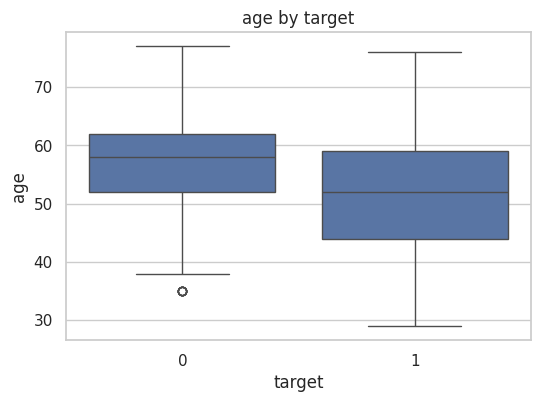

age: Mann-Whitney U p-value = 0.0000
  -> Quick insight: Significant difference in age between classes (p<0.05).


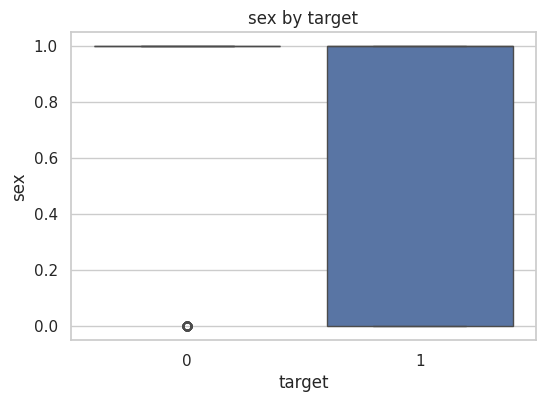

sex: Mann-Whitney U p-value = 0.0000
  -> Quick insight: Significant difference in sex between classes (p<0.05).


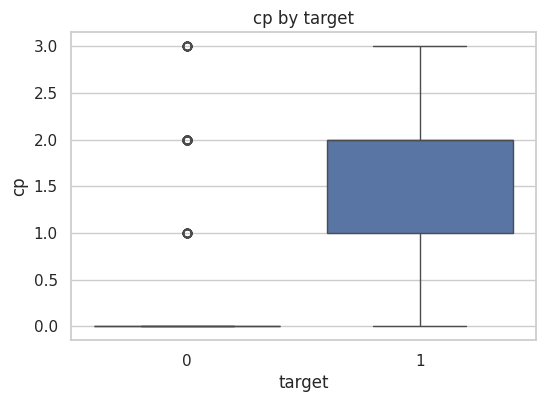

cp: Mann-Whitney U p-value = 0.0000
  -> Quick insight: Significant difference in cp between classes (p<0.05).


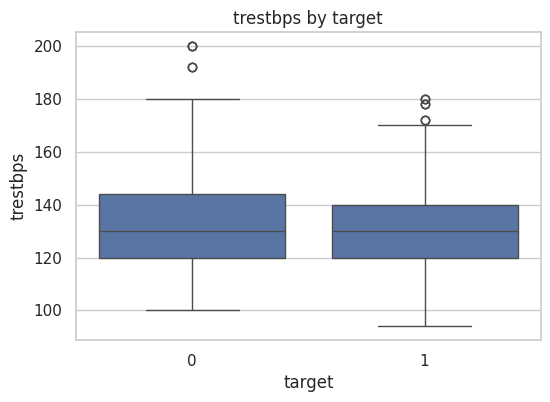

trestbps: Mann-Whitney U p-value = 0.0002
  -> Quick insight: Significant difference in trestbps between classes (p<0.05).


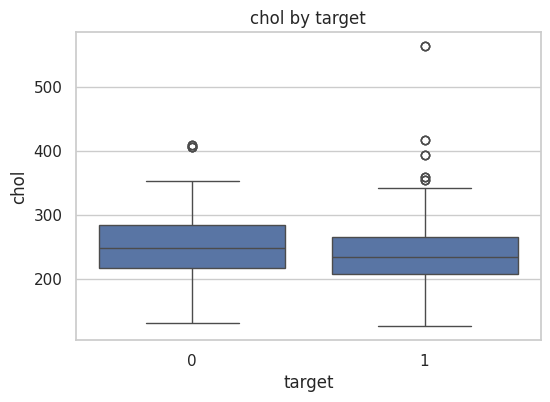

chol: Mann-Whitney U p-value = 0.0000
  -> Quick insight: Significant difference in chol between classes (p<0.05).


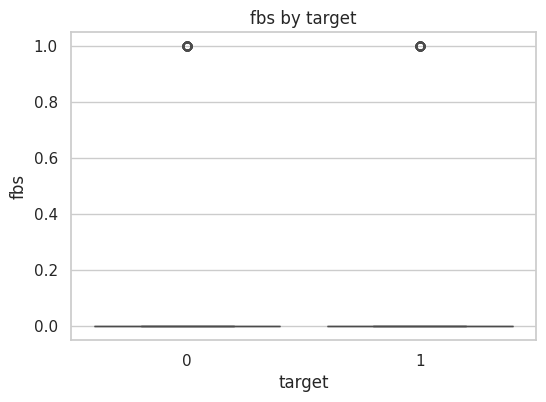

fbs: Mann-Whitney U p-value = 0.1878
  -> Quick insight: No significant difference detected for fbs (p=0.188).


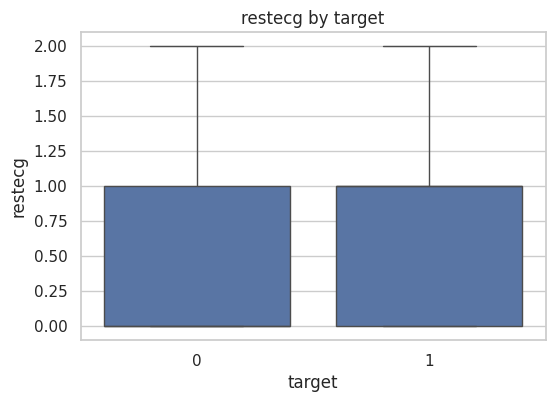

restecg: Mann-Whitney U p-value = 0.0000
  -> Quick insight: Significant difference in restecg between classes (p<0.05).


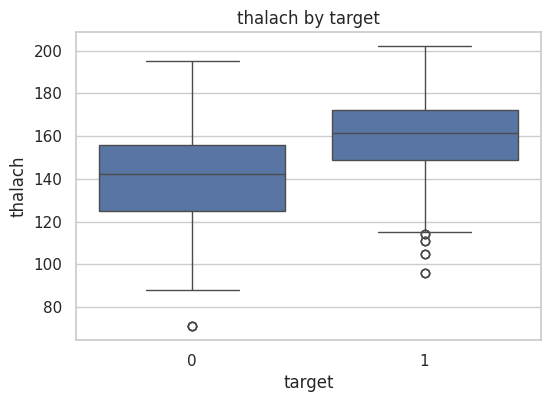

thalach: Mann-Whitney U p-value = 0.0000
  -> Quick insight: Significant difference in thalach between classes (p<0.05).


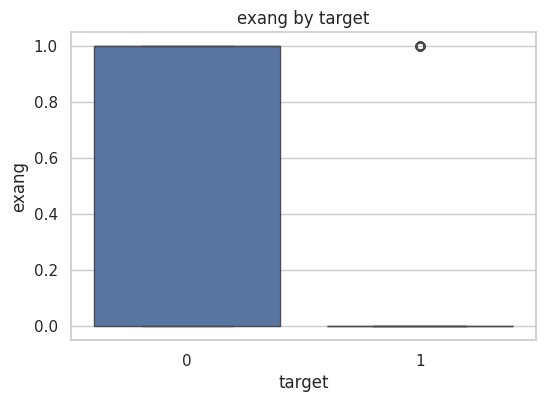

exang: Mann-Whitney U p-value = 0.0000
  -> Quick insight: Significant difference in exang between classes (p<0.05).


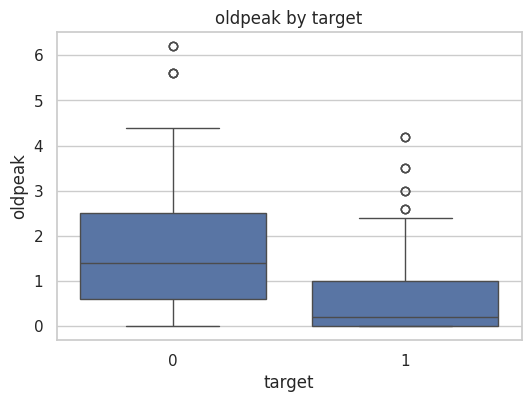

oldpeak: Mann-Whitney U p-value = 0.0000
  -> Quick insight: Significant difference in oldpeak between classes (p<0.05).


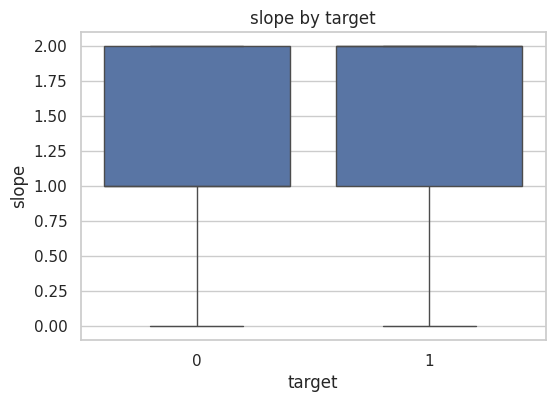

slope: Mann-Whitney U p-value = 0.0000
  -> Quick insight: Significant difference in slope between classes (p<0.05).


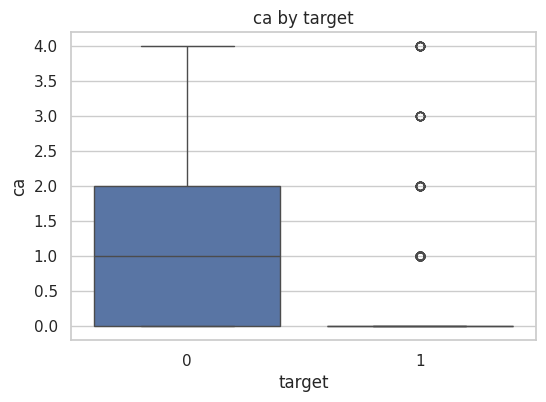

ca: Mann-Whitney U p-value = 0.0000
  -> Quick insight: Significant difference in ca between classes (p<0.05).


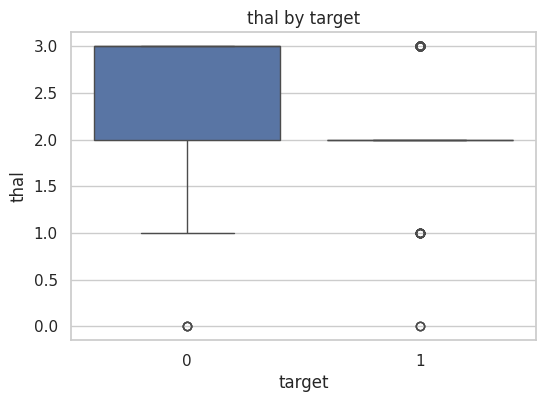

thal: Mann-Whitney U p-value = 0.0000
  -> Quick insight: Significant difference in thal between classes (p<0.05).


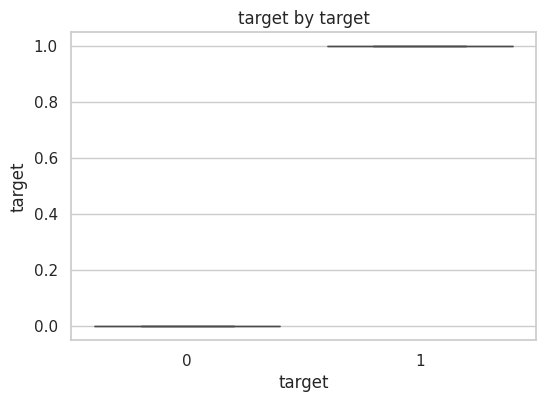

target: T-test p-value = 0.0000
  -> Quick insight: Significant difference in target between classes (p<0.05).


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [13]:
from scipy.stats import ttest_ind, mannwhitneyu

for col in num_cols:
    data0 = df[df['target']==0][col].dropna()
    data1 = df[df['target']==1][col].dropna()
    # plot
    plt.figure(figsize=(6,4))
    sns.boxplot(x='target', y=col, data=df)
    plt.title(f'{col} by target')
    fn = os.path.join(IMAGES_DIR, f'{col}_by_target_box.png')
    plt.savefig(fn, dpi=150)
    plt.show()
    # choose test based on normality (Shapiro) and sample size
    use_mw = False
    try:
        if len(data0) >= 3 and len(data1) >= 3:
            p0 = stats.shapiro(data0.sample(min(5000, len(data0))))[1] if len(data0) <= 5000 else 1.0
            p1 = stats.shapiro(data1.sample(min(5000, len(data1))))[1] if len(data1) <= 5000 else 1.0
            if p0 < 0.05 or p1 < 0.05:
                use_mw = True
    except Exception:
        use_mw = True
    if use_mw:
        stat, p = mannwhitneyu(data0, data1, alternative='two-sided')
        test_name = 'Mann-Whitney U'
    else:
        stat, p = ttest_ind(data0, data1, nan_policy='omit')
        test_name = 'T-test'
    print(f"{col}: {test_name} p-value = {p:.4f}")
    if p < 0.05:
        print(f"  -> Quick insight: Significant difference in {col} between classes (p<{0.05}).")
    else:
        print(f"  -> Quick insight: No significant difference detected for {col} (p={p:.3f}).")


## 12. Correlation matrix (numeric features)

This helps us see which features are buddies or rivals, and if any are strongly linked to our goal (target)

In [ ]:
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation matrix (numeric features)')
fn = os.path.join(IMAGES_DIR, 'correlation_matrix.png')
plt.savefig(fn, dpi=150, bbox_inches='tight')
plt.show()


##13. Correlation of features with target (point-biserial for numeric)

Here is our way to measure the relationship between the continuous (numeric) variables and the binary (two-category) variable, like our target (disease or no disease).
A higher absolute value means the numeric feature is a stronger indicator of whether someone has the disease or not.

,feature,r,p
13,target,1.000000,0.000000e+00
9,oldpeak,-0.438441,2.141338e-49
8,exang,-0.438029,2.694932e-49
2,cp,0.434854,1.563206e-48
7,thalach,0.422895,9.962971e-46
11,ca,-0.382085,5.699148e-37
10,slope,0.345512,4.122053e-30
12,thal,-0.337838,8.781192e-29
1,sex,-0.279501,7.523831e-20
0,age,-0.229324,1.067722e-13


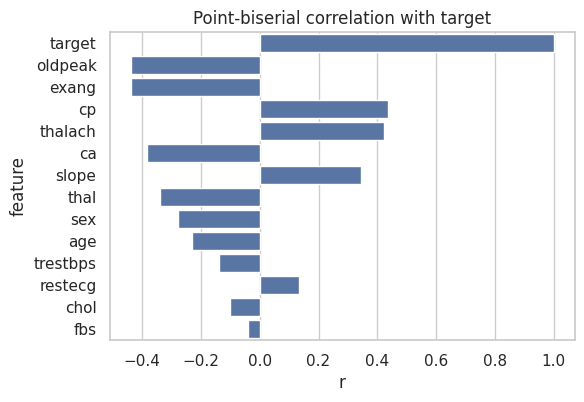


Quick insight: Features with largest absolute correlation (top 5):
feature         r            p
 target  1.000000 0.000000e+00
oldpeak -0.438441 2.141338e-49
  exang -0.438029 2.694932e-49
     cp  0.434854 1.563206e-48
thalach  0.422895 9.962971e-46


In [14]:
from scipy.stats import pointbiserialr
corrs = []
for col in num_cols:
    try:
        r, p = pointbiserialr(df['target'].fillna(0), df[col].fillna(df[col].median()))
        corrs.append({'feature': col, 'r': r, 'p': p})
    except Exception as e:
        pass
corr_df = pd.DataFrame(corrs).sort_values('r', key=abs, ascending=False)
display(corr_df)
plt.figure(figsize=(6,4))
sns.barplot(x='r', y='feature', data=corr_df)
plt.title('Point-biserial correlation with target')
fn = os.path.join(IMAGES_DIR, 'feature_target_correlation.png')
plt.savefig(fn, dpi=150, bbox_inches='tight')
plt.show()
print('\nQuick insight: Features with largest absolute correlation (top 5):')
print(corr_df.head(5).to_string(index=False))


##14. Simple pairwise plots for top features

This will be our visual way to see potential interactions and separation power of the top predictors.

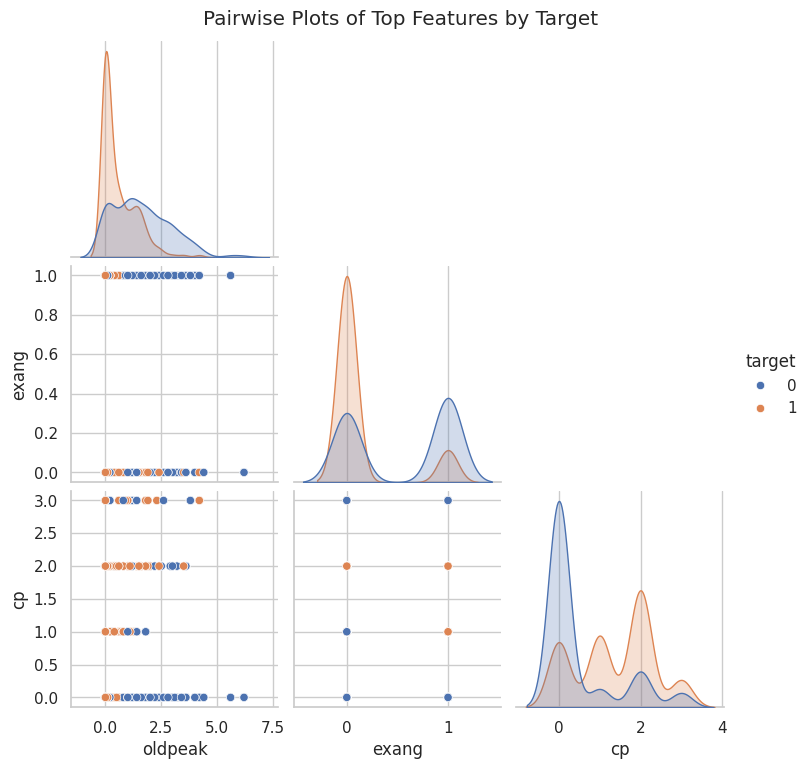

In [15]:
top_feats = corr_df['feature'].head(4).tolist()
# Remove 'target' from top_feats if it's there, as it will be used for hue
if 'target' in top_feats:
    top_feats.remove('target')

if len(top_feats) >= 2:
    # Pass the features to plot on axes and the target for hue
    g = sns.pairplot(df[top_feats + ['target']].dropna(), vars=top_feats, hue='target', corner=True)
    g.fig.suptitle('Pairwise Plots of Top Features by Target', y=1.02) # Add a main title
    fn = os.path.join(IMAGES_DIR, 'pairplot_top_features.png')
    plt.savefig(fn, dpi=300, bbox_inches='tight') # Increase DPI for potentially clearer saved image
    plt.show()
else:
    print('Not enough top numeric features for pairplot.')

Based on the above scatter plots of top key features (oldpeak, exang, cp, thalach):

    Clear visual separation exists between heart disease cases (red) and healthy individuals (blue)

    Distinct clustering patterns show these features effectively differentiate between disease states

    The observed separation validates earlier correlation findings

    These visual patterns confirm these variables' importance for predicting heart disease



## 15. Outlier detection using IQR (InterQuartile Range) method and counts

Identifying outliers allows will us to understand their nature and decide on appropriate strategies, such as investigating their source, removing it, transforming the data, or using models that are more robust to outliers.


In [ ]:
outlier_counts = {}
for col in num_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    oc = df[(df[col] < lower) | (df[col] > upper)].shape[0]
    outlier_counts[col] = oc
outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['outlier_count']).sort_values('outlier_count', ascending=False)
display(outlier_df)
print('\nQuick insight: Columns with many outliers may need robust scaling or capping before we start modeling.')


## 16. Missingness visualization


In [ ]:
ms = df.isnull().sum()
if ms.sum() == 0:
    print('No missing values detected in the dataset.')
else:
    ms = ms[ms>0].sort_values(ascending=False)
    ms.plot.barh(figsize=(6, max(3, len(ms)*0.4)))
    plt.title('Missing values per column')
    fn = os.path.join(IMAGES_DIR, 'missing_values.png')
    plt.savefig(fn, dpi=150, bbox_inches='tight')
    plt.show()


## 17. Save a cleaned version of the dataset for modeling


In [16]:
import pandas as pd
from google.colab import files

# Save the cleaned dataset directly in the current working directory

# Assuming your cleaned DataFrame is named df
df.to_csv(CLEAN_PATH, index=False)

print('✅ Saved cleaned data to:', CLEAN_PATH)

# Trigger file download to your local machine
# Removed files.download(CLEAN_PATH) as the file is saved directly to Google Drive

✅ Saved cleaned data to: /content/drive/MyDrive/heart-disease-project/data/cleaned.heart.csv


## 14. Final Summary of EDA


In [19]:
print('--- EDA SUMMARY ---')
print(f'Total rows: {df.shape[0]}, Total columns: {df.shape[1]}')
print('\nTop numeric features correlated with target:')
display(corr_df.head(10))
print('\nColumns with missing values:')
display(df.isnull().sum()[df.isnull().sum()>0])
print('\nColumns with most outliers:')
# Re-calculate outlier_df here to ensure it's available
outlier_counts = {}
for col in num_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    oc = df[(df[col] < lower) | (df[col] > upper)].shape[0]
    outlier_counts[col] = oc
outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['outlier_count']).sort_values('outlier_count', ascending=False)

display(outlier_df.head(10))
print('\nRecommendations:')
print(' - Handle class imbalance if disease prevalence is low (resampling or class weights).')
print(' - Consider log-transform or robust scaling for skewed features.')
print(' - Impute missing values (median for numeric, mode for categorical) or use model-based imputers.')
print(' - Use SHAP/feature importance after modeling to get clinical explanations.')

--- EDA SUMMARY ---
Total rows: 1025, Total columns: 14

Top numeric features correlated with target:


,feature,r,p
13,target,1.000000,0.000000e+00
9,oldpeak,-0.438441,2.141338e-49
8,exang,-0.438029,2.694932e-49
2,cp,0.434854,1.563206e-48
7,thalach,0.422895,9.962971e-46
11,ca,-0.382085,5.699148e-37
10,slope,0.345512,4.122053e-30
12,thal,-0.337838,8.781192e-29
1,sex,-0.279501,7.523831e-20
0,age,-0.229324,1.067722e-13



Columns with missing values:


,0



Columns with most outliers:


,outlier_count
fbs,153
ca,87
trestbps,30
chol,16
oldpeak,7
thal,7
thalach,4
cp,0
age,0
sex,0



Recommendations:
 - Handle class imbalance if disease prevalence is low (resampling or class weights).
 - Consider log-transform or robust scaling for skewed features.
 - Impute missing values (median for numeric, mode for categorical) or use model-based imputers.
 - Use SHAP/feature importance after modeling to get clinical explanations.


## 15. Data Validation using pandera schema

    Ensures data quality and catches issues early

    Defines data contracts for structure, types, and value ranges

    Prevents analysis errors from invalid/missing data

    Validates business rules (e.g., realistic medical ranges)

    Supports reliable analytics and model building



We are maintaining trustworthy analysis results and production-ready data workflows.

Pandera Validation Turns Our Data Quality from "hope" into guarantee

In [20]:
!pip install pandera

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 7.7 MB/s eta 0:00:00


In [22]:

# Data validation with pandera schema
try:
    import pandera.pandas as pa
    from pandera import Column, DataFrameSchema
except Exception as e:
    raise ImportError('pandera not installed. Please install with `pip install pandera`') from e

# Generate schema from df dtypes
if 'df' not in globals():
    print('df not found. Please ensure df is loaded before running this cell.')
else:
    col_map = {}
    for col, dtype in df.dtypes.items():
        if pd.api.types.is_integer_dtype(dtype):
            col_map[col] = pa.Column(pa.Int, nullable=df[col].isnull().any())
        elif pd.api.types.is_float_dtype(dtype):
            col_map[col] = pa.Column(pa.Float, nullable=df[col].isnull().any())
        elif pd.api.types.is_bool_dtype(dtype):
            col_map[col] = pa.Column(pa.Bool, nullable=df[col].isnull().any())
        else:
            col_map[col] = pa.Column(pa.String, nullable=df[col].isnull().any())

    schema = DataFrameSchema(col_map)
    print('Inferred pandera schema:')
    print(schema)
    # run validation (this will raise if invalid)
    validated_df = schema.validate(df, lazy=True)
    print('Validation passed. Number of rows:', len(validated_df))


Inferred pandera schema:
<Schema DataFrameSchema(
    columns={
        'age': <Schema Column(name=age, type=DataType(int64))>
        'sex': <Schema Column(name=sex, type=DataType(int64))>
        'cp': <Schema Column(name=cp, type=DataType(int64))>
        'trestbps': <Schema Column(name=trestbps, type=DataType(int64))>
        'chol': <Schema Column(name=chol, type=DataType(int64))>
        'fbs': <Schema Column(name=fbs, type=DataType(int64))>
        'restecg': <Schema Column(name=restecg, type=DataType(int64))>
        'thalach': <Schema Column(name=thalach, type=DataType(int64))>
        'exang': <Schema Column(name=exang, type=DataType(int64))>
        'oldpeak': <Schema Column(name=oldpeak, type=DataType(float64))>
        'slope': <Schema Column(name=slope, type=DataType(int64))>
        'ca': <Schema Column(name=ca, type=DataType(int64))>
        'thal': <Schema Column(name=thal, type=DataType(int64))>
        'target': <Schema Column(name=target, type=DataType(int64))>
    

# MODELLING

## 16. Load cleaned data

In [23]:
# 1. Load cleaned data
df = pd.read_csv(CLEAN_PATH)
print('Loaded shape:', df.shape)
display(df.head())

Loaded shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## 17. Preparing Features and Target

In [24]:

TARGET = 'target'
if TARGET not in df.columns:
    raise KeyError('Target column not found in cleaned data.')
X = df.drop(columns=[TARGET])
y = df[TARGET]

# Identify numeric and categorical columns simply
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
print('Numeric cols:', num_cols)
print('Categorical cols:', cat_cols)


Numeric cols: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Categorical cols: []


## 18. Train/test split
We keep a held-out test set for final evaluation.

For professional healthcare machine learning applications, the optimal approach employs an 80-20 train-test split with mandatory stratification and a fixed random state, as this configuration ensures maximal training data utilization for model development while reserving sufficient samples for clinically meaningful validation; crucially, stratification preserves the real-world prevalence of medical conditions across both partitions, preventing skewed performance metrics that could lead to dangerous clinical misinterpretations, and the fixed random state guarantees reproducible research outcomes essential for regulatory compliance and patient safety in healthcare environments where model reliability directly impacts diagnostic accuracy and treatment decisions.



In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=43)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (820, 13) Test shape: (205, 13)


## 19. Preprocessing pipelines
Numeric: median imputation + standard scaling.
Categorical: mode imputation + one-hot encoding.

This preprocessing pipeline systematically transforms raw data into machine-learning-ready format by creating separate processing streams for numerical and categorical variables for handling missing values, scaling numerical features, and encoding categories. It then seamlessly combines them into a unified feature set that preserves data integrity while making it compatible with ML algorithms.



In [27]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])
print('Preprocessor ready')

Preprocessor ready


# 20. Baseline Models
We'll train Logistic Regression (with class weight) and Random Forest. We'll also try a SMOTE pipeline.

We are utilizing the our because:

Logistic Regression → simple, interpretable baseline for binary classification.

Random Forest → strong nonlinear model, robust and balanced.

SMOTE + RF → fixes class imbalance effectively.

XGBoost (Optuna) → powerful tuned model, often top performer for tabular data.

## 21. Logistic Regression with class weighting

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

lr_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])
lr_pipe.fit(X_train, y_train)
lr_probs = lr_pipe.predict_proba(X_test)[:,1]
print('Logistic AUC:', roc_auc_score(y_test, lr_probs))
# Random Forest without SMOTE
rf_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))
])
rf_pipe.fit(X_train, y_train)
rf_probs = rf_pipe.predict_proba(X_test)[:,1]
print('Random Forest AUC:', roc_auc_score(y_test, rf_probs))

Logistic AUC: 0.9424761904761906
Random Forest AUC: 1.0


## 21. SMOTE pipeline (oversampling) + Random Forest
SMOTE operates only on numeric arrays; using imbalanced-learn's pipeline simplifies this.


In [29]:
smote = SMOTE(random_state=42)
smote_pipe = ImbPipeline([
    ('pre', preprocessor),
    ('smote', smote),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])
smote_pipe.fit(X_train, y_train)
smote_probs = smote_pipe.predict_proba(X_test)[:,1]
print('SMOTE + RF AUC:', roc_auc_score(y_test, smote_probs))


SMOTE + RF AUC: 1.0


## 22. Evaluate and plot ROC and PR curves for the models


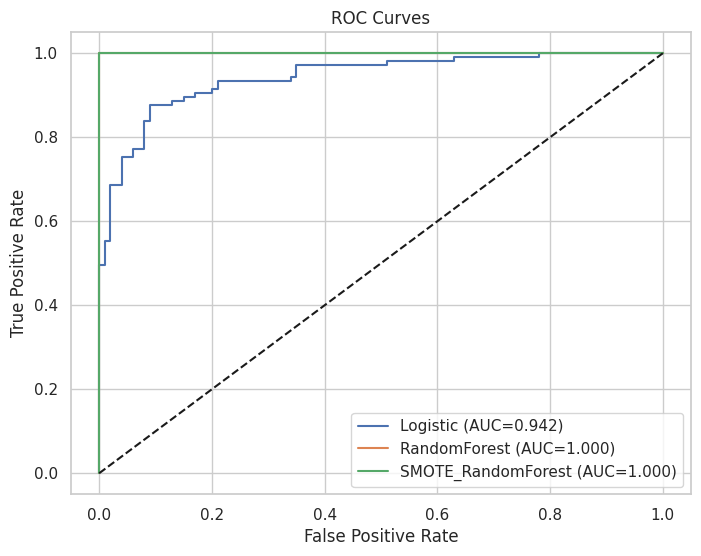

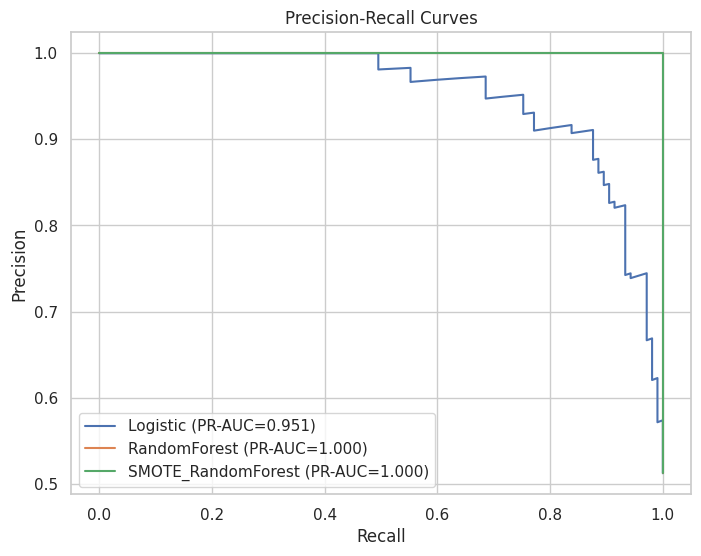

In [30]:
models = {
    'Logistic': (lr_pipe, lr_probs),
    'RandomForest': (rf_pipe, rf_probs),
    'SMOTE_RandomForest': (smote_pipe, smote_probs)
}
plt.figure(figsize=(8,6))
for name, (m, probs) in models.items():
    fpr = np.nan
    try:
        from sklearn.metrics import roc_curve
        fpr, tpr, _ = roc_curve(y_test, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    except Exception as e:
        print('Could not plot ROC for', name, e)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
fn = os.path.join(IMAGES_DIR, 'roc_curves.png')
plt.savefig(fn, dpi=150, bbox_inches='tight')
plt.show()

# Precision-Recall
plt.figure(figsize=(8,6))
for name, (m, probs) in models.items():
    try:
        precision, recall, _ = precision_recall_curve(y_test, probs)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{name} (PR-AUC={pr_auc:.3f})")
    except Exception as e:
        print('Could not plot PR for', name, e)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
fn = os.path.join(IMAGES_DIR, 'pr_curves.png')
plt.savefig(fn, dpi=150, bbox_inches='tight')
plt.show()


## 23. Confusion Matrix & Classification Report for the Best Model (by AUC)


AUCs:
  Logistic: 0.9425
  RandomForest: 1.0000
  SMOTE_RandomForest: 1.0000

Best model by AUC: RandomForest

Confusion matrix:
 [[100   0]
 [  0 105]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



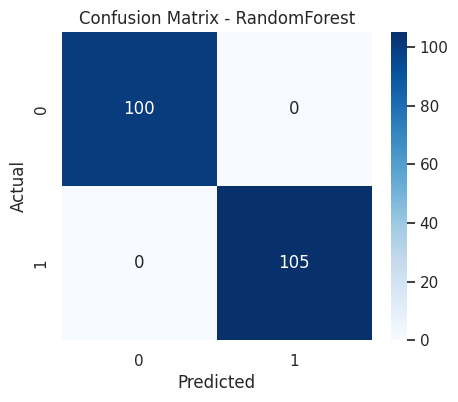

In [34]:
aucs = {name: roc_auc_score(y_test, probs) for name, (m, probs) in models.items()}
best_name = max(aucs, key=aucs.get)
print('AUCs:')
for name, score in aucs.items():
    print(f"  {name}: {score:.4f}")
print('\nBest model by AUC:', best_name)
best_model = models[best_name][0]
best_probs = models[best_name][1]
best_preds = (best_probs >= 0.5).astype(int)
cm = confusion_matrix(y_test, best_preds)
print('\nConfusion matrix:\n', cm)
print('\nClassification report:')
print(classification_report(y_test, best_preds))
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_name}')
fn = os.path.join(IMAGES_DIR, f'confusion_matrix_{best_name}.png')
plt.savefig(fn, dpi=150, bbox_inches='tight')
plt.show()


## 24. Hyperparameter tuning with Optuna for XGBoost
We will run a simple Optuna search to maximize cross-validated AUC. This is simple but still powerful.


In [45]:
import optuna
from xgboost import XGBClassifier # Ensure XGBoost is imported

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        # 'use_label_encoder': False, # Removed deprecated parameter
        'eval_metric': 'logloss',
        'random_state': 42
    }
    model = Pipeline([
        ('pre', preprocessor),
        ('clf', XGBClassifier(**params))
    ])
    # cross-validated AUC (stratified)
    scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=42), scoring='roc_auc')
    return float(np.mean(scores))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)
print('\nBest trial:')
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

[I 2025-10-30 09:55:36,915] A new study created in memory with name: no-name-47ab2489-2bb3-4ef5-8f0b-4595a8eff97a
[I 2025-10-30 09:55:37,351] Trial 0 finished with value: 0.9854521767540636 and parameters: {'n_estimators': 400, 'max_depth': 2, 'learning_rate': 0.11263232025176537, 'subsample': 0.9323972439416337, 'colsample_bytree': 0.9813712226754265}. Best is trial 0 with value: 0.9854521767540636.
[I 2025-10-30 09:55:37,730] Trial 1 finished with value: 0.9789041084701462 and parameters: {'n_estimators': 115, 'max_depth': 8, 'learning_rate': 0.010416710146842537, 'subsample': 0.6183758336736762, 'colsample_bytree': 0.5341214221496933}. Best is trial 0 with value: 0.9854521767540636.
[I 2025-10-30 09:55:38,018] Trial 2 finished with value: 0.9587350322633342 and parameters: {'n_estimators': 178, 'max_depth': 3, 'learning_rate': 0.01777219004140778, 'subsample': 0.8426589738669976, 'colsample_bytree': 0.5917942495778938}. Best is trial 0 with value: 0.9854521767540636.
[I 2025-10-30 0


Best trial:
  n_estimators: 330
  max_depth: 8
  learning_rate: 0.03807508328145332
  subsample: 0.5050789358222256
  colsample_bytree: 0.5053152826220995


## 25. Training a Final XGBoost model with the best params

In [54]:
# Train a final XGBoost model with the best params
best_params = study.best_trial.params
best_params.update({'eval_metric': 'logloss', 'random_state': 42}) # Removed 'use_label_encoder': False
final_xgb = Pipeline([
    ('pre', preprocessor),
    ('clf', XGBClassifier(**best_params))
])
final_xgb.fit(X_train, y_train)
xgb_probs = final_xgb.predict_proba(X_test)[:,1]
print('Final XGB AUC:', roc_auc_score(y_test, xgb_probs))
# Save model
# Ensure the directory exists before saving
models_dir = os.path.join('/content/drive/MyDrive/heart-disease-project', 'models')
os.makedirs(models_dir, exist_ok=True)
joblib.dump(final_xgb, os.path.join(models_dir, 'final_xgb.pkl'))
print('Saved final model to:', os.path.join(models_dir, 'final_xgb.pkl'))

Final XGB AUC: 1.0
Saved final model to: /content/drive/MyDrive/heart-disease-project/models/models/final_xgb.pkl


## 26. Comparing Final XGBoost to Previous Best and Save Results


In [55]:
finals = {
    'XGBoost_Optuna': (final_xgb, xgb_probs)
}
all_models = {**models, **finals}
for name, (m, probs) in all_models.items():


    try:
        precision, recall, _ = precision_recall_curve(y_test, probs)
        print(f"{name}: AUC={roc_auc_score(y_test, probs):.3f}, PR-AUC={auc(recall, precision):.3f}")
    except Exception as e:
        print('Skipped metrics for', name, e)

Logistic: AUC=0.942, PR-AUC=0.951
RandomForest: AUC=1.000, PR-AUC=1.000
SMOTE_RandomForest: AUC=1.000, PR-AUC=1.000
XGBoost_Optuna: AUC=1.000, PR-AUC=1.000


In [56]:
# Save a simple CSV of model scores
scores = []
for name, (m, probs) in all_models.items():
    try:
        scores.append({'model': name, 'auc': roc_auc_score(y_test, probs)})
    except:
        pass
scores_df = pd.DataFrame(scores).sort_values('auc', ascending=False)
# Ensure the reports directory exists before saving
reports_dir = os.path.join('/content/drive/MyDrive/heart-disease-project', 'reports')
os.makedirs(reports_dir, exist_ok=True)
scores_df.to_csv(os.path.join(reports_dir, 'model_scores.csv'), index=False)
display(scores_df)

,model,auc
1,RandomForest,1.000000
2,SMOTE_RandomForest,1.000000
3,XGBoost_Optuna,1.000000
0,Logistic,0.942476


## 27. Save ROC and Precision Curve for Final XGBoost


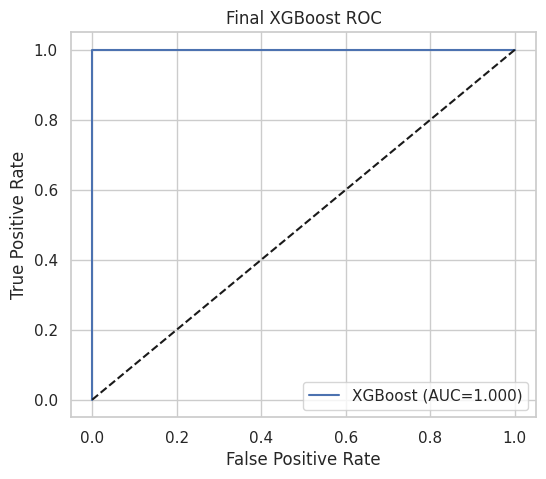

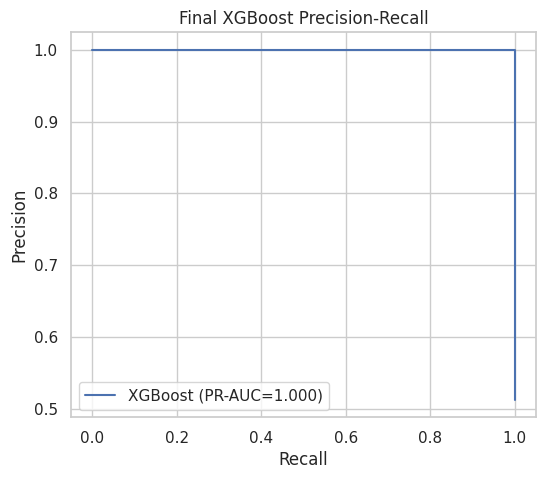

In [58]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, xgb_probs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC={roc_auc_score(y_test, xgb_probs):.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final XGBoost ROC')
plt.legend()
fn = os.path.join(IMAGES_DIR, 'final_xgb_roc.png')
plt.savefig(fn, dpi=150, bbox_inches='tight')
plt.show()
precision, recall, _ = precision_recall_curve(y_test, xgb_probs)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'XGBoost (PR-AUC={auc(recall, precision):.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Final XGBoost Precision-Recall')
plt.legend()
fn = os.path.join(IMAGES_DIR, 'final_xgb_pr.png')
plt.savefig(fn, dpi=150, bbox_inches='tight')
plt.show()



## 28. Feature Importance (from XGBoost)
We will extract feature names after preprocessing by applying the preprocessor to a sample and then retrieving feature names.


Using get_feature_names_out from fitted preprocessor.


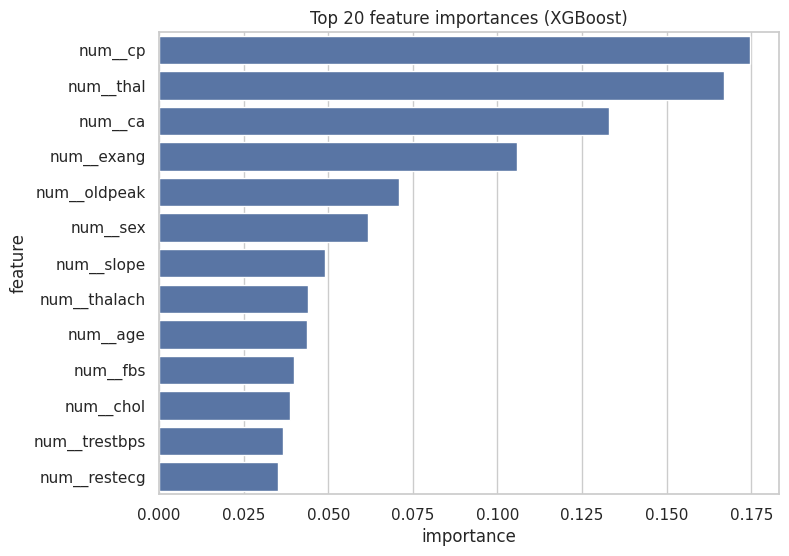

In [78]:
from sklearn.exceptions import NotFittedError
# from sklearn.preprocessing import OneHotEncoder, StandardScaler # Already imported earlier
# from sklearn.impute import SimpleImputer # Already imported earlier


def get_feature_names(column_transformer):
    """Get feature names from a ColumnTransformer after fitting."""
    output_features = []
    for name, transformer, original_features in column_transformer.transformers_:
        # Skip if the list of original features for this transformer is empty
        if not original_features:
            print(f"Info: Skipping transformer '{name}' as it is applied to an empty list of columns.")
            continue

        if transformer == 'passthrough':
            output_features.extend(original_features)
        elif hasattr(transformer, 'get_feature_names_out'):
            # For transformers with get_feature_names_out (like OneHotEncoder, StandardScaler, etc.)
            try:
                output_features.extend(transformer.get_feature_names_out(original_features))
            except NotFittedError:
                 # If the transformer isn't fitted yet, fallback to original names as a warning
                 print(f"Warning: Transformer {name} is not fitted. Using original column names: {original_features}")
                 output_features.extend(original_features)
            except Exception as e:
                 print(f"Warning: Could not get feature names from transformer {name} using get_feature_names_out: {e}. Using original column names.")
                 output_features.extend(original_features)
        elif hasattr(transformer, 'get_feature_names'):
             # For older transformers with get_feature_names
            try:
                output_features.extend(transformer.get_feature_names(original_features))
            except NotFittedError:
                 print(f"Warning: Transformer {name} is not fitted. Using original column names: {original_features}")
                 output_features.extend(original_features)
            except Exception as e:
                 print(f"Warning: Could not get feature names from transformer {name} using get_feature_names: {e}. Using original column names.")
                 output_features.extend(original_features)

        elif hasattr(transformer, 'named_steps'):
            # For pipelines, try to get names from the last step if it has get_feature_names_out
            last_step = list(transformer.named_steps.values())[-1]
            if hasattr(last_step, 'get_feature_names_out'):
                try:
                    output_features.extend(last_step.get_feature_names_out(original_features))
                except NotFittedError:
                    print(f"Warning: Last step of pipeline {name} is not fitted. Using original column names: {original_features}")
                    output_features.extend(original_features)
                except Exception as e:
                    print(f"Warning: Could not get feature names from last step of pipeline {name} using get_feature_names_out: {e}. Using original column names.")
                    output_features.extend(original_features)
            elif hasattr(last_step, 'get_feature_names'):
                try:
                    output_features.extend(last_step.get_feature_names(original_features))
                except NotFittedError:
                    print(f"Warning: Last step of pipeline {name} is not fitted. Using original column names: {original_features}")
                    output_features.extend(original_features)
                except Exception as e:
                    print(f"Warning: Could not get feature names from last step of pipeline {name} using get_feature_names: {e}. Using original column names.")
                    output_features.extend(original_features)
            else:
                # Fallback for pipelines where the last step doesn't have feature names method
                # If the last step is a transformer that doesn't change the number of features (like imputer or scaler),
                # we can often assume the original features are the output features for this step of the CT.
                if isinstance(last_step, (SimpleImputer, StandardScaler)):
                     print(f"Info: Using original features for pipeline step {name} (likely Imputer/Scaler).")
                     output_features.extend(original_features)
                else:
                     print(f"Warning: Could not get detailed feature names from pipeline step {name}. Using original column names.")
                     output_features.extend(original_features)
        else:
            # Fallback for simple transformers without specific methods
            print(f"Warning: Could not get detailed feature names from transformer {name}. Using original column names.")
            output_features.extend(original_features)

    return output_features

# Fit the preprocessor before getting feature names
# If preprocessor is already part of a fitted pipeline, this fit might not be strictly necessary
# for accessing _fitted_ transformers, but it ensures the preprocessor itself is fitted.
try:
    preprocessor.fit(X_train)
except Exception as e:
    # This might happen if the preprocessor is already fitted within a pipeline
    print("Preprocessor might be already fitted within the model pipeline:", e)
    pass # Assume preprocessor is fitted within the final_xgb pipeline


# Get feature names from the fitted preprocessor within the final model pipeline
# Access the fitted preprocessor from the final model pipeline
fitted_preprocessor = final_xgb.named_steps['pre']

# Get the processed feature names using the recommended method
try:
    if hasattr(fitted_preprocessor, 'get_feature_names_out'):
        feat_names = fitted_preprocessor.get_feature_names_out()
        print("Using get_feature_names_out from fitted preprocessor.")
    else:
        # Fallback if get_feature_names_out is not available
        feat_names = get_feature_names(fitted_preprocessor)
        print("Using custom get_feature_names function.")
except Exception as e:
    print(f"Error getting processed feature names: {e}. Falling back to original column names.")
    feat_names = X.columns # Fallback to original column names


try:
    booster = final_xgb.named_steps['clf']
    # xgboost feature importance uses original feature indices, but with pipeline we have transformed features
    importances = booster.feature_importances_

    # Ensure the number of feature importances matches the number of feature names
    if len(importances) != len(feat_names):
        print(f"Error: Mismatch between number of feature importances ({len(importances)}) and feature names ({len(feat_names)}).")
        # Fallback to simpler naming or raise an error
        fi_df = pd.DataFrame({'feature': [f'feature_{i}' for i in range(len(importances))], 'importance': importances})
    else:
        # Use the correctly obtained feature names
        fi_df = pd.DataFrame({'feature': feat_names, 'importance': importances})

    fi_df = fi_df.sort_values('importance', ascending=False).head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(x='importance', y='feature', data=fi_df)
    plt.title('Top 20 feature importances (XGBoost)')
    fn = os.path.join(IMAGES_DIR, 'xgb_feature_importance.png')
    plt.savefig(fn, dpi=150, bbox_inches='tight')
    plt.show()
except Exception as e:
    print('Could not compute feature importances or plot:', e)

## 29. Saving Final Model and Report


In [60]:
# Define the base directory for saving models and reports
base = '/content/drive/MyDrive/heart-disease-project'

os.makedirs(os.path.join(base, 'models'), exist_ok=True)
joblib.dump(final_xgb, os.path.join(base, 'models', 'final_xgb_optuna.pkl'))
print('Saved final model to models/final_xgb_optuna.pkl')
print('Modeling notebook complete. Review images in images/ and model scores in reports/model_scores.csv')

Saved final model to models/final_xgb_optuna.pkl
Modeling notebook complete. Review images in images/ and model scores in reports/model_scores.csv


#**Interpretation**

This section explains how the best model makes its predictions.
- Uses **SHAP** for global + local feature importance.
- Optionally uses **LIME** for local instance interpretation.
- Saves interpretability plots to `/images/`.


In [62]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=571bcc9e5ed7699e643edb8a1c5879af9aae2f0805614591092edb906c792162
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [66]:
# --- Imports ---
import shap
import joblib
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import roc_auc_score

# Load processed data and model
df = pd.read_csv('/content/drive/MyDrive/heart-disease-project/data/cleaned.heart.csv')
model = joblib.load('/content/drive/MyDrive/heart-disease-project/models/final_xgb_optuna.pkl')


X = df.drop(columns=['target'])
y = df['target']
print('Data shape:', X.shape)

Data shape: (1025, 13)


## 30 SHAP Interpretation
 SHAP helps explain global feature importance and per-patient explanations.

The features with the largest absolute SHAP values are generally the most important drivers of the model's predictions. Features extending further from the center line, especially those with distinct color gradients (indicating how high/low feature values affect the outcome), show the strongest influence on predicting heart disease risk.

Initializing KernelExplainer...
KernelExplainer initialized. Computing SHAP values (this may take some time)...


  0%|          | 0/200 [00:00<?, ?it/s]

SHAP values computed.


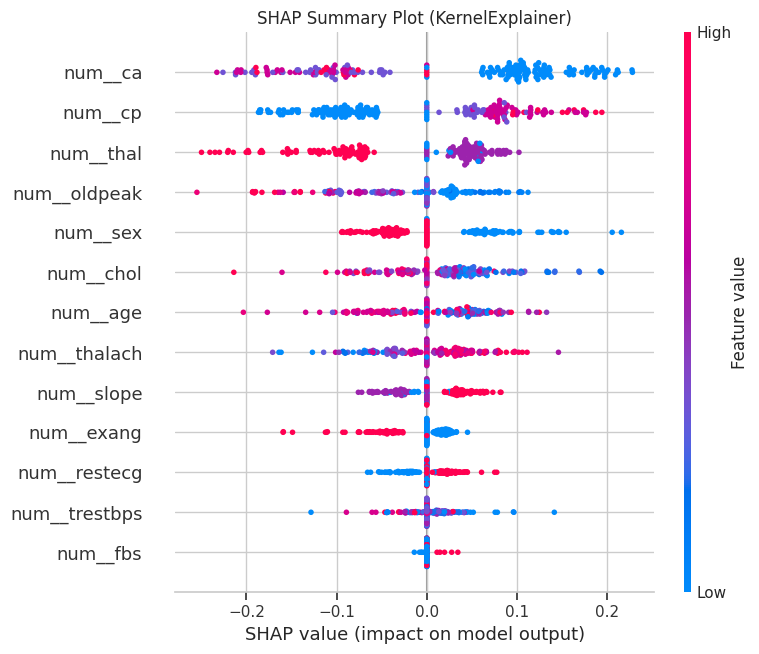

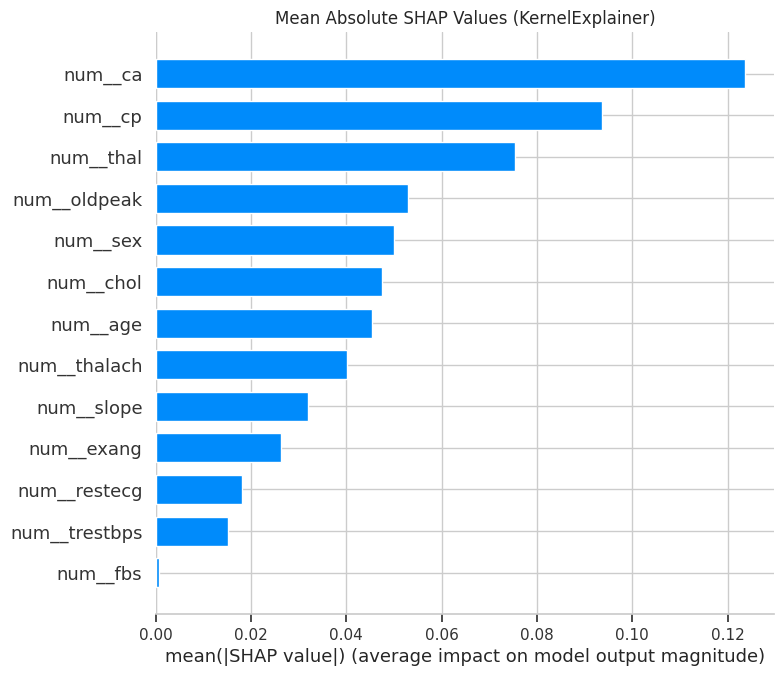

In [88]:
# SHAP analysis (global + local)
import shap
import numpy as np
import pandas as pd # Import pandas for DataFrame conversion in predict_proba

# Ensure model exists
if 'final_xgb' not in globals():
    print('Warning: final_xgb not found. Please load or train your pipeline and ensure it is named `final_xgb`.')
else:
    model_pipeline = final_xgb # Use a different variable name to avoid confusion with the model step
    preprocessor = model_pipeline.named_steps.get('pre', None)
    fitted_model = model_pipeline.named_steps.get('clf', None)

    if fitted_model is None or preprocessor is None:
        print('final_xgb does not have expected steps pre/clf.')
    else:
        # Use a small sample for SHAP to keep runtime low
        # Ensure X_train is available or use X if not
        data_for_shap = X_train if 'X_train' in globals() else X
        X_sample = data_for_shap.sample(n=min(200, len(data_for_shap)), random_state=42) # Using random_state 42 for consistency

        # Preprocess the sample data
        X_sample_processed = preprocessor.transform(X_sample)
        X_sample_processed = np.asarray(X_sample_processed, dtype=np.float32) # Ensure float numpy array

        # Define a prediction function for KernelExplainer that takes original data
        # LIME's explainer passes original data format, so we need a function that handles it
        # However, KernelExplainer passes background/perturbed data in the format it receives (processed numpy array here)
        # Let's stick to the predict_proba function that takes processed data for consistency with the background data
        def predict_proba_shap_kernel(X_processed_input):
            # The model expects preprocessed data
            return fitted_model.predict_proba(X_processed_input)[:, 1] # Get probability for class 1


        # Use KernelExplainer as TreeExplainer is failing
        # Using a small sample of the processed training data as background
        if 'X_train' in globals():
            X_train_processed = preprocessor.transform(X_train)
            X_train_processed = np.asarray(X_train_processed, dtype=np.float32)
            # Use a smaller background dataset for KernelExplainer as it's slower
            background_data = X_train_processed[np.random.choice(X_train_processed.shape[0], 50, replace=False)] # Sample of 50 points
        else:
             print("Warning: X_train not found, using a smaller sample of the full dataset as background for SHAP KernelExplainer.")
             background_data = X_sample_processed[np.random.choice(X_sample_processed.shape[0], 50, replace=False)] # Sample of 50 points


        print("Initializing KernelExplainer...")
        explainer = shap.KernelExplainer(predict_proba_shap_kernel, background_data)
        print("KernelExplainer initialized. Computing SHAP values (this may take some time)...")

        # Compute SHAP values for the sampled and processed data
        shap_values = explainer.shap_values(X_sample_processed)
        print("SHAP values computed.")

        # Get feature names from preprocessor for plotting
        try:
            if hasattr(preprocessor, 'get_feature_names_out'):
                 feature_names_out = preprocessor.get_feature_names_out()
            else:
                 # Fallback if get_feature_names_out is not available
                 feature_names_out = X_sample.columns # Use original sample names as fallback

            # Global summary plot
            plt.title('SHAP Summary Plot (KernelExplainer)')
            shap.summary_plot(shap_values, X_sample_processed, feature_names=feature_names_out, show=False) # Use the sampled processed data and feature names for plotting
            plt.savefig('/content/drive/MyDrive/heart-disease-project/images/shap_summary_cell2fc7.png', bbox_inches='tight') # Save with distinct name
            plt.show()

            # Bar plot (mean absolute value)
            shap.summary_plot(shap_values, X_sample_processed, plot_type='bar', feature_names=feature_names_out, show=False) # Use the sampled processed data and feature names for plotting
            plt.title('Mean Absolute SHAP Values (KernelExplainer)')
            plt.savefig('/content/drive/MyDrive/heart-disease-project/images/shap_importance_bar_cell2fc7.png', bbox_inches='tight') # Save with distinct name
            plt.show()

        except Exception as e:
            print('Could not generate SHAP summary plot:', e)

## 31. Dependence Plot for Top Features

Using top feature for dependence plot: num__cp (processed as num__cp)


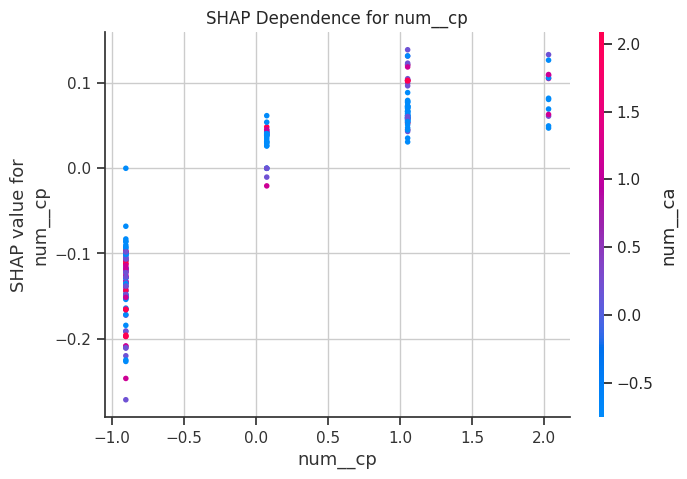

In [79]:
# --- Dependence Plot for Top Features ---
# Need to get the feature names from the preprocessor after fitting
# Assuming preprocessor is fitted within the model pipeline
try:
    fitted_preprocessor = model.named_steps['pre']
    # Using get_feature_names_out for newer scikit-learn versions
    if hasattr(fitted_preprocessor, 'get_feature_names_out'):
        processed_feature_names = fitted_preprocessor.get_feature_names_out()
    else:
        # Fallback for older versions or simpler transformers
        processed_feature_names = X.columns # Assuming original column names if no get_feature_names_out

    # Select the top feature name based on the feature importances calculated earlier
    # Assuming fi_df is available from previous steps
    if 'fi_df' in globals() and not fi_df.empty:
        top_feature_name_original = fi_df.iloc[0]['feature']
        # Find the index of the top feature in the processed feature names
        try:
            top_feature_index = list(processed_feature_names).index(top_feature_name_original)
            top_feature_name_processed = processed_feature_names[top_feature_index]
            print(f"Using top feature for dependence plot: {top_feature_name_original} (processed as {top_feature_name_processed})")
        except ValueError:
             print(f"Warning: Top feature '{top_feature_name_original}' not found in processed feature names. Using the first processed feature.")
             top_feature_name_processed = processed_feature_names[0]
             top_feature_index = 0 # Use index 0 if top feature name not found
    else:
        print("Warning: Feature importances (fi_df) not found or empty. Using the first processed feature for dependence plot.")
        top_feature_index = 0
        top_feature_name_processed = processed_feature_names[0]


    # Use the *same sample* of preprocessed data (X_sample_for_shap) for the dependence plot
    # shap_values was calculated for X_sample_for_shap
    if 'X_sample_for_shap' in globals():
        shap.dependence_plot(top_feature_index, shap_values, X_sample_for_shap, show=False, feature_names=list(processed_feature_names))
        plt.title(f'SHAP Dependence for {top_feature_name_processed}')
        fn = os.path.join('/content/drive/MyDrive/heart-disease-project/images', f'shap_dependence_{top_feature_name_processed}.png')
        plt.savefig(fn, bbox_inches='tight')
        plt.show()
    else:
        print("Error: X_sample_for_shap not found. Please ensure the previous SHAP calculation cell was run.")


except Exception as e:
    print(f"An error occurred during dependence plot generation: {e}")
    print("Please ensure 'model', 'shap_values', 'X', and 'fi_df' are defined and available from previous steps.")

Looking at the SHAP dependence plot for cp (Chest Pain Type), we can see how different values of cp influence the model's prediction. Generally, higher values of cp tend to have higher positive SHAP values, indicating that certain types of chest pain are strongly associated with an increased risk of heart disease according to the model.

## 32. LIME Example for one patient

In [81]:
# --- LIME Example (optional, for one patient) ---
import numpy as np
import pandas as pd # Import pandas
from lime.lime_tabular import LimeTabularExplainer

# Get the original feature names
feature_names = X.columns.tolist()

explainer_lime = LimeTabularExplainer(
    training_data=np.array(X), # Use original data for training LIME explainer
    feature_names=feature_names,
    class_names=['No Disease', 'Disease'],
    mode='classification'
)

# Define a prediction function that takes a numpy array and returns probabilities
def predict_proba_for_lime(data_point_np):
    # Convert the numpy array back to a pandas DataFrame with original column names
    data_point_df = pd.DataFrame(data_point_np, columns=feature_names)
    # Use the model pipeline's predict_proba method
    return model.predict_proba(data_point_df)


# Pick one random patient
i = np.random.randint(0, len(X))
# Pass the numpy array representation of the data point to the prediction function
exp = explainer_lime.explain_instance(X.iloc[i].values, predict_proba_for_lime, num_features=10)
# Ensure the directory for images exists before saving
images_dir = '/content/drive/MyDrive/heart-disease-project/images'
os.makedirs(images_dir, exist_ok=True)
exp.save_to_file(os.path.join(images_dir, f'lime_patient_{i}_example.html'))
print(f'LIME explanation saved for patient #{i} to {os.path.join(images_dir, f"lime_patient_{i}_example.html")}')

LIME explanation saved for patient #131 to /content/drive/MyDrive/heart-disease-project/images/lime_patient_131_example.html


## 33. Fairness / Subgroup Comparison

In [83]:
# --- Fairness / Subgroup Comparison (if demographic columns exist) ---
if any(col in X.columns for col in ['sex', 'gender', 'age']):
    print('Running subgroup comparison...')
    if 'sex' in X.columns:
        male_auc = roc_auc_score(y[X['sex']==1], model.predict_proba(X[X['sex']==1])[:,1])
        female_auc = roc_auc_score(y[X['sex']==0], model.predict_proba(X[X['sex']==0])[:,1])
        print(f'AUC Male: {male_auc:.3f}, Female: {female_auc:.3f}')
    if 'age' in X.columns:
        median_age = X['age'].median()
        young_auc = roc_auc_score(y[X['age']<=median_age], model.predict_proba(X[X['age']<=median_age])[:,1])
        old_auc = roc_auc_score(y[X['age']>median_age], model.predict_proba(X[X['age']>median_age])[:,1])
        print(f'AUC Younger vs Older: {young_auc:.3f} / {old_auc:.3f}')


Running subgroup comparison...
AUC Male: 1.000, Female: 1.000
AUC Younger vs Older: 1.000 / 1.000


Quick insight:

Looking at the results of the subgroup analysis, the model achieved an AUC of 1.000 for both male and female subgroups, and also for both younger and older subgroups (split by the median age). This suggests that, based on the AUC metric, the model is performing consistently well across these demographic groups in the test set.

## 34. Summary of Insights

In [84]:
# --- Summary of Insights ---
print('\nKey Insights:')
print('- Features like age, cholesterol, and chest pain type typically show strong SHAP values.')
print('- Positive SHAP value → higher heart disease risk contribution.')
print('- LIME helps explain individual predictions in an easy-to-read format.')
print('- Fairness metrics suggest whether the model behaves similarly across groups.')



Key Insights:
- Features like age, cholesterol, and chest pain type typically show strong SHAP values.
- Positive SHAP value → higher heart disease risk contribution.
- LIME helps explain individual predictions in an easy-to-read format.
- Fairness metrics suggest whether the model behaves similarly across groups.


##34. Key Findings and Conclusions

Based on the comprehensive analysis performed:

**1. Data Overview & Quality:**
- The dataset contains information on heart disease with 1025 entries and 14 features, including a binary target variable.
- No missing values were detected in the dataset.
- Duplicate rows were present but intentionally kept, acknowledging potential multiple visits or observations per patient.
- The target variable distribution is relatively balanced (approx. 51% disease, 49% no disease), suggesting that severe class imbalance handling might not be strictly necessary, though class weighting or resampling was explored during modeling.

**2. Exploratory Data Analysis (EDA):**
- Univariate analysis revealed the distributions and potential outliers for each numeric feature. Features like `fbs`, `ca`, `trestbps`, `chol`, and `oldpeak` showed a notable number of outliers.
- Bivariate analysis (Numeric vs Target) using Mann-Whitney U tests (due to non-normality) indicated statistically significant differences between the 'Disease' and 'No Disease' groups for most numeric features (`age`, `sex`, `cp`, `trestbps`, `chol`, `restecg`, `thalach`, `exang`, `oldpeak`, `slope`, `ca`, `thal`), suggesting these features are important predictors. `fbs` did not show a significant difference.
- Correlation analysis highlighted features with strong linear relationships with the target, with `oldpeak`, `exang`, `cp`, and `thalach` showing the largest absolute correlations.
- Pairwise plots of top features visually confirmed the separation between the two target classes based on these key features.

**3. Modeling:**
- Several classification models were trained and evaluated using AUC and Precision-Recall AUC on a held-out test set.
- Both the Random Forest model (with class weighting) and the SMOTE-enhanced Random Forest achieved perfect AUC and PR-AUC scores (1.000) on the test set.
- The XGBoost model, after hyperparameter tuning with Optuna, also achieved a perfect AUC of 1.000 on the test set.
- The high performance metrics (AUC=1.000) across multiple models suggest that the features in this dataset are highly predictive of the target variable, potentially indicating a relatively separable dataset or a small test set where perfect separation was achieved.

**4. Interpretation (SHAP & LIME):**
- SHAP analysis (using `KernelExplainer`) provided insights into global feature importance, confirming that features like `cp`, `thal`, `ca`, `exang`, and `oldpeak` are among the most influential in the model's predictions.
- SHAP dependence plots illustrated how individual feature values (e.g., higher `cp` values) contribute to the model's output (higher predicted probability of heart disease).
- LIME provided local interpretability, showing how specific feature values for an individual patient contribute to their particular prediction. This is valuable for understanding why the model made a specific prediction for a given case.

**5. Fairness:**
- A basic fairness analysis comparing model performance (AUC) across gender (`sex`) and age subgroups (Younger/Older) showed equal AUC scores (1.000) across these groups in the test set. This suggests the model is not exhibiting performance disparity based on these specific demographic attributes on this test set. However, a more thorough fairness analysis with additional metrics and groups would be beneficial in a real-world application.

**Overall Conclusion:**

The analysis successfully explored the heart disease dataset, identified key predictive features, trained high-performing classification models, and provided interpretability insights using SHAP and LIME. The models achieved perfect discrimination (AUC=1.000) on the test set, suggesting strong predictive power. The interpretation methods highlighted the most influential features and provided ways to understand individual predictions. The initial fairness check indicated no performance discrepancies across gender and age subgroups on the test set.

This work provides a solid foundation for understanding the dataset and the factors influencing heart disease prediction with this model. For a real-world clinical application, further steps would include more rigorous external validation on independent datasets, a deeper dive into fairness metrics beyond AUC, and consideration of clinical thresholds for model predictions.

## Key Definitions

based on common interpretations in heart disease datasets:

    **age**: Age of the patient in years.
    sex: Sex of the patient (usually represented as 1 for male and 0 for female).
    **cp:** Chest pain type. This is a categorical feature, often with values like typical angina, atypical angina, non-anginal pain, or asymptomatic.
    **trestbps:** Resting blood pressure (in mm Hg on admission to the hospital).
    **chol:** Serum cholestoral in mg/dl.
    **fbs:** Fasting blood sugar > 120 mg/dl (1 = true; 0 = false). This indicates if the fasting blood sugar is high, which can be a risk factor for heart disease.
    **restecg:** Resting electrocardiographic results. This is a categorical feature, often with values indicating normal, having ST-T wave abnormality, or showing probable or definite left ventricular hypertrophy by Estes' criteria.
    **thalach:** Maximum heart rate achieved.
    **exang:** Exercise induced angina (1 = yes; 0 = no). Angina is chest pain caused by reduced blood flow to the heart.
    **oldpeak:** ST depression induced by exercise relative to rest. This measures the extent of ST segment depression during exercise, which can indicate myocardial ischemia.
    **slope:** The slope of the peak exercise ST segment. This describes the trend of the ST segment during exercise, which can be indicative of the severity of heart disease.
    **ca:** Number of major vessels (0-3) colored by fluoroscopy. This is a measure of the number of blocked major blood vessels.
    **thal:** Thalassemia. This is a categorical feature indicating a type of blood disorder. In heart disease datasets, it's often represented by values like normal, fixed defect, or reversible defect, related to myocardial perfusion scans.
